# Rapid Compression Machine (Coupled Reactors)

Code is ported (almost) verbatim from cantera example file `reactor2.py` (distributed with cantera):
```
"""
Two reactors connected with a piston, with heat loss to the environment

This script simulates the following situation. A closed cylinder with volume 2
m^3 is divided into two equal parts by a massless piston that moves with speed
proportional to the pressure difference between the two sides.  It is
initially held in place in the middle. One side is filled with 1000 K argon at
20 atm, and the other with a combustible 500 K methane/air mixture at 0.1 atm
(phi = 1.1). At t = 0 the piston is released and begins to move due to the
large pressure difference, compressing and heating the methane/air mixture,
which eventually explodes. At the same time, the argon cools as it expands.
The piston is adiabatic, but some heat is lost through the outer cylinder
walls to the environment.

Note that this simulation, being zero-dimensional, takes no account of shock
wave propagation. It is somewhat artifical, but nevertheless instructive.
"""
```

In [1]:
#import sys
#import os
#import csv
import numpy as np
import cantera as ct

import matplotlib.pyplot as plt
%matplotlib notebook

First create each gas needed, and a reactor or reservoir for each one.

In [2]:
# create an argon gas object and set its state
ar = ct.Solution('argon.xml')
ar.TP = 1000.0, 20.0 * ct.one_atm

# create a reactor to represent the side of the cylinder filled with argon
r1 = ct.IdealGasReactor(ar)

# create a reservoir for the environment, and fill it with air.
env = ct.Reservoir(ct.Solution('air.xml'))

# use GRI-Mech 3.0 for the methane/air mixture, and set its initial state
gas = ct.Solution('gri30.xml')
gas.TP = 500.0, 0.2 * ct.one_atm
gas.set_equivalence_ratio(1.1, 'CH4:1.0', 'O2:2, N2:7.52')

# create a reactor for the methane/air side
r2 = ct.IdealGasReactor(gas)

Now couple the reactors by defining common walls that may move (a piston) or
conduct heat

In [3]:
# add a flexible wall (a piston) between r2 and r1
w = ct.Wall(r2, r1, A=1.0, K=0.5e-4, U=100.0)

# heat loss to the environment. Heat loss always occur through walls, so we
# create a wall separating r1 from the environment, give it a non-zero area,
# and specify the overall heat transfer coefficient through the wall.
w2 = ct.Wall(r2, env, A=1.0, U=500.0)

sim = ct.ReactorNet([r1, r2])

# Now the problem is set up, and we're ready to solve it.
print('finished setup, begin solution...')

time = 0.0
n_steps = 300
#outfile = open('piston.csv', 'w')
#csvfile = csv.writer(outfile)
#csvfile.writerow(['time (s)','T1 (K)','P1 (Bar)','V1 (m3)',
#                  'T2 (K)','P2 (Bar)','V2 (m3)'])
states1 = ct.SolutionArray(ar, extra=['t', 'V'])
states2 = ct.SolutionArray(gas, extra=['t', 'V'])

for n in range(n_steps):
    time += 4.e-4
    print(n, time, r2.T)
    sim.advance(time)
    states1.append(r1.thermo.state, t=time, V=r1.volume)
    states2.append(r2.thermo.state, t=time, V=r2.volume)
    #csvfile.writerow([time, r1.thermo.T, r1.thermo.P, r1.volume,
    #                  r2.thermo.T, r2.thermo.P, r2.volume])
    
#outfile.close()
#print('Output written to file piston.csv')
#print('Directory: '+os.getcwd())

finished setup, begin solution...
0 0.0004 500.0
1 0.0008 506.9042452529438
2 0.0012000000000000001 513.6996290013775
3 0.0016 520.4177565969471
4 0.002 527.0847257759873
5 0.0024000000000000002 533.7226596488559
6 0.0028000000000000004 540.3507677963609
7 0.0032000000000000006 546.9860942655603
8 0.0036000000000000008 553.6440683639406
9 0.004000000000000001 560.3389171550124
10 0.004400000000000001 567.0839831217781
11 0.004800000000000001 573.891975155092
12 0.0052000000000000015 580.7751699397611
13 0.005600000000000002 587.7455793727818
14 0.006000000000000002 594.8150917291556
15 0.006400000000000002 601.9955937244076
16 0.006800000000000002 609.2990784550643
17 0.007200000000000002 616.7377426620582
18 0.007600000000000003 624.3240759909324
19 0.008000000000000002 632.0709441695044
20 0.008400000000000001 639.9916671939567
21 0.0088 648.1000932466059
22 0.0092 656.4106684166827
23 0.0096 664.9385016727939
24 0.009999999999999998 673.6994238896182
25 0.010399999999999998 682.7100

<IPython.core.display.Javascript object>


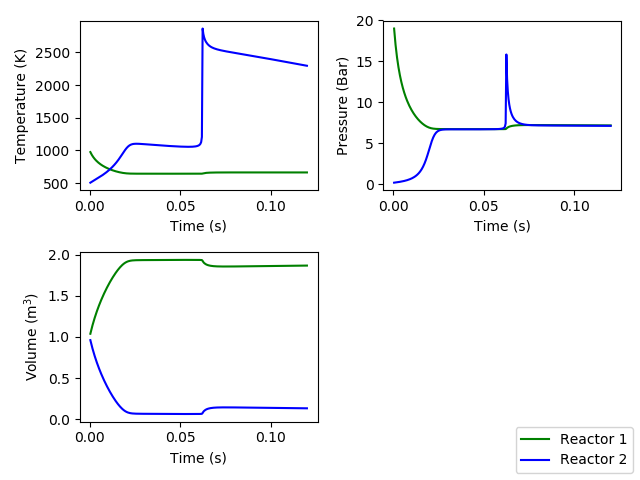

In [4]:
plt.clf()
plt.subplot(2,2,1)
h = plt.plot(states1.t, states1.T, 'g-', states2.t, states2.T, 'b-')
#plt.legend(['Reactor 1','Reactor 2'],2)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

plt.subplot(2,2,2)
plt.plot(states1.t, states1.P / 1e5, 'g-', states2.t, states2.P / 1e5, 'b-')
#plt.legend(['Reactor 1','Reactor 2'],2)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Bar)')

plt.subplot(2,2,3)
plt.plot(states1.t, states1.V, 'g-', states2.t, states2.V,'b-')
#plt.legend(['Reactor 1','Reactor 2'],2)
plt.xlabel('Time (s)')
plt.ylabel('Volume (m$^3$)')

plt.figlegend(h, ['Reactor 1', 'Reactor 2'], loc='lower right')
plt.tight_layout()
#    plt.show()
#else:
#    print("""To view a plot of these results, run this script with the option -plot""")